In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import nltk
import os
import seaborn as sns

import plotly.graph_objects as go
import plotly.io as pio
pio.templates.default = "plotly_white"

# supress warnings
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)

from scipy.stats import ttest_ind


import matplotlib.pyplot as plt


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
root_path = '/content/drive/My Drive/airbnb/nyc-airbnb/'
files = os.listdir(root_path)
dates = [f[4:] for f in files if f.startswith('nyc')]
dates = sorted(dates)

In [4]:
dates

['2022-11-02',
 '2022-12-04',
 '2023-01-04',
 '2023-02-05',
 '2023-03-06',
 '2023-04-05',
 '2023-05-03',
 '2023-06-05',
 '2023-07-03',
 '2023-08-04',
 '2023-09-05',
 '2023-10-01',
 '2023-11-01']

In [5]:
dfs = {}
for date in dates:
  path = f'{root_path}nyc-{date}/listings.csv.gz'
  temp = pd.read_csv(path, compression = 'gzip')
  temp['price'] = temp['price'].str.replace("$", "").str.replace(",", "").astype(float)
  dfs[date] = temp

In [6]:
basic_info = []

for i in range(0, len(dates)):
  metrics = {
      'counts_of_listing': len(dfs[dates[i]]),
      'mean_of_price': dfs[dates[i]]['price'].mean(),
      'avg_avalibility_365': dfs[dates[i]]['availability_365'].mean(),
      'avg_number_review': dfs[dates[i]]['number_of_reviews'].mean()
  }
  if i == 0:
    metrics["drop"] = None
  else:
    cur = dfs[dates[i]]
    pre = dfs[dates[i - 1]]
    list_drop = [list_id for list_id in pre.id.values if list_id not in cur.id.values]
    metrics['drop'] = len(list_drop)
  basic_info.append(metrics)

metrics_df = pd.DataFrame(basic_info, index=pd.to_datetime(dates))
metrics_df

,counts_of_listing,mean_of_price,avg_avalibility_365,avg_number_review,drop
2022-11-02,39544,217.993071,135.607020,26.853176,NaN
2022-12-04,41533,221.978282,143.287771,26.204994,1327.0
2023-01-04,42754,194.558544,148.517589,25.929644,1809.0
2023-02-05,42739,187.747818,144.025340,25.879688,2820.0
2023-03-06,42931,200.307167,140.262211,25.856001,2197.0
2023-04-05,43241,210.992091,137.890567,25.751648,2133.0
2023-05-03,43303,216.099574,135.048011,25.995150,2173.0
2023-06-05,43566,225.216109,136.998256,26.368544,2125.0
2023-07-03,43729,217.068399,138.756272,26.789613,1827.0
2023-08-04,43582,212.093640,139.080194,26.971915,2056.0


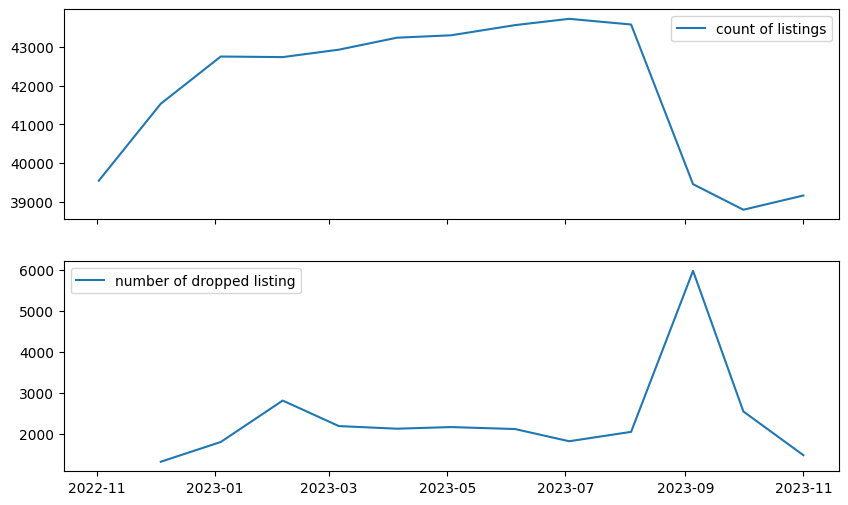

In [7]:
fig, ax = plt.subplots(2, figsize=[10,6], sharex=True)
ax[0].plot([pd.to_datetime(date) for date in dates],
 metrics_df['counts_of_listing'], label="count of listings")
ax[1].plot([pd.to_datetime(date) for date in dates],
 metrics_df['drop'], label="number of dropped listing")
ax[0].legend()
ax[1].legend()

In [8]:
before_df = dfs['2023-08-04']
after_df = dfs['2023-09-05']

In [9]:
id_drop = [id for id in before_df.id.values if id not in after_df.id.values]
before_df['dropped'] =  before_df['id'].isin(id_drop).astype(int)

In [10]:
one_hot_encoded_df = pd.get_dummies(before_df['neighbourhood_group_cleansed'], prefix='neighborhood_')
before_df = before_df.join(one_hot_encoded_df)
before_df['instant_bookable_'] = before_df['instant_bookable'].map({'f': 0, 't': 1}).fillna(0)
before_df['host_is_superhost_'] = before_df['host_is_superhost'].map({'f':0, 't':1}).fillna(0)

In [11]:
before_df.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'name',
       'description', 'neighborhood_overview', 'picture_url', 'host_id',
       'host_url', 'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'ca

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
import statsmodels.api as sm
from sklearn.model_selection import KFold

x = before_df.copy()
## nights that greater than 30days becomes 1, otherwise 0
x["maximum_nights_30"] = x["maximum_nights"] // 30
x["maximum_nights_30"] = np.minimum(x["maximum_nights_30"], 1)
x["accommodates_2"] = np.minimum(x["accommodates"], 10)

x['host_since'] = pd.to_datetime(x['host_since'])
x['host_years'] = 2023 - x['host_since'].dt.year

x['instant_bookable_'] = x['instant_bookable'].map({'f': 0, 't': 1}).fillna(0)
x['host_is_superhost_'] = x['host_is_superhost'].map({'f':0, 't':1}).fillna(0)

x = x[x["price"] != 0]
x["log_price"] = np.log(x["price"])

x['constant'] = 1

x.loc[x["review_scores_rating"] < 4.5, "rating"] = 0
x.loc[(x["review_scores_rating"] >= 4.5) & (x["review_scores_rating"] < 4.8), "rating"] = 1
x.loc[(x["review_scores_rating"] >= 4.8), "rating"] = 2

x["host_listings_count"] = np.minimum(x["host_listings_count"], 5)
x["num_rating_per_year"] = np.log((x["number_of_reviews"]+1) / np.maximum(x["host_years"],1))
x = x[x["neighbourhood_group_cleansed"].isin(["Brooklyn","Manhattan","Queens"])]

neighborhood_dummy = [
                      'neighborhood__Brooklyn',
                      'neighborhood__Queens',
                      ]
# minimum_nights_neighborhood = []
# for nei in neighborhood_dummy:
#   col = f"minimum_nights_{nei}"
#   x[col] = x["minimum_nights_30"] * x[nei]
#   minimum_nights_neighborhood.append(col)

scaler = StandardScaler()
scaler_needed_columns = ['log_price',
                         'availability_30',
                         'beds',
                         'host_listings_count',
                         'rating',
                         'host_years',
                         'maximum_nights_30'
                         ]

x[scaler_needed_columns] = scaler.fit_transform(x[scaler_needed_columns])

initial_columns = ['constant']+scaler_needed_columns+[
                                         'instant_bookable_',
                                         'host_is_superhost_'
                                         ] + neighborhood_dummy

x = x[x[initial_columns].notnull().all(axis=1)]
X = x[initial_columns]
y = x['dropped']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)
sm_model = sm.Logit(y_train, X_train)
sm_res = sm_model.fit()

y_pred_prob = sm_res.predict(X_test)
# p_pred = sm_res.predict_proba(X_test)

sm_res.summary()

Optimization terminated successfully.
         Current function value: 0.512100
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                dropped   No. Observations:                41990
Model:                          Logit   Df Residuals:                    41978
Method:                           MLE   Df Model:                           11
Date:                Sun, 10 Dec 2023   Pseudo R-squ.:                  0.2612
Time:                        07:37:36   Log-Likelihood:                -21503.
converged:                       True   LL-Null:                       -29105.
Covariance Type:            nonrobust   LLR p-value:                     0.000
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
constant                  -0.3504      0.021    -16.475      0.000      -0.392      -0.309
log_price                  0.2763      0.017     16.005      0.000       0.242       0.310
availability_30            0.0994      0.013      7.372      0.000       0.073       0.126
beds                      -0.0920      0.014     -6.455      0.000      -0.120      -0.064
host_listings_count       -0.0577      0.014     -4.124      0.000      -0.085      -0.030
rating                    -0.0774      0.013     -5.948      0.000      -0.103      -0.052
host_years                -0.2406      0.013    -18.623      0.000      -0.266      -0.215
maximum_nights_30         -0.9892      0.010    -96.162      0.000      -1.009      -0.969
instant_bookable_         -0.2891      0.032     -8.924      0.000      -0.353      -0.226
host_is_superhost_        -0.0203      0.029     -0.690      0.490      -0.078       0.037
neighborhood__Brooklyn    -0.1281      0.028     -4.566      0.000      -0.183      -0.073
neighborhood__Queens      -0.1602      0.037     -4.316      0.000      -0.233      -0.087
==========================================================================================
"""

In [13]:
y_pred = [1 if x > 0.5 else 0 for x in y_pred_prob]
z = pd.DataFrame({"test": y_test, "pred": y_pred})
z.groupby(["test","pred"]).apply(len)

test  pred
0     0       4735
      1        489
1     0        391
      1        550
dtype: int64

In [14]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.91      0.91      5224
           1       0.53      0.58      0.56       941

    accuracy                           0.86      6165
   macro avg       0.73      0.75      0.74      6165
weighted avg       0.86      0.86      0.86      6165



In [15]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
VIFs = pd.Series(
    [variance_inflation_factor(X.values, i) for i in range(X.shape[1])],
    index=X_train.columns
)
print(VIFs)

constant                  3.278479
log_price                 1.572687
availability_30           1.186511
beds                      1.339134
host_listings_count       1.192039
rating                    1.177002
host_years                1.168873
maximum_nights_30         1.039054
instant_bookable_         1.080242
host_is_superhost_        1.161815
neighborhood__Brooklyn    1.351568
neighborhood__Queens      1.405030
dtype: float64


In [16]:
### Using False discovery rate to set a significance threshold for multiple comparison
def fdr(pvals, level=0.01):
  thresholds = pvals.sort_values().rank() / pvals.size * level
  significance = pd.DataFrame({"pvalues": pvals, "thresholds": thresholds})
  significance["significant"] = False
  significance.loc[significance["pvalues"] < significance["thresholds"], "significant"] = True
  return significance
fdr(sm_res.pvalues)

,pvalues,thresholds,significant
availability_30,1.685250e-13,0.005000,True
beds,1.081929e-10,0.005833,True
constant,5.523719e-61,0.002500,True
host_is_superhost_,4.899112e-01,0.010000,False
host_listings_count,3.716136e-05,0.009167,True
host_years,2.072703e-77,0.001667,True
instant_bookable_,4.489439e-19,0.004167,True
log_price,1.179401e-57,0.003333,True
maximum_nights_30,0.000000e+00,0.000833,True
neighborhood__Brooklyn,4.968747e-06,0.007500,True


In [17]:
feature_importance = pd.DataFrame({'coefficient':sm_res.params,
                                   'z_score': sm_res.tvalues,
                                   'p_value': sm_res.pvalues},
                                  index=X_train.columns).sort_values(by='z_score')
feature_importance['p_value'] = feature_importance['p_value'].map('{:.4f}'.format)
feature_importance

,coefficient,z_score,p_value
maximum_nights_30,-0.989153,-96.161547,0.0000
host_years,-0.240608,-18.623486,0.0000
constant,-0.350432,-16.475275,0.0000
instant_bookable_,-0.289138,-8.924197,0.0000
beds,-0.092005,-6.455036,0.0000
rating,-0.077370,-5.947617,0.0000
neighborhood__Brooklyn,-0.128084,-4.566103,0.0000
neighborhood__Queens,-0.160162,-4.315995,0.0000
host_listings_count,-0.057729,-4.124455,0.0000
host_is_superhost_,-0.020309,-0.690450,0.4899


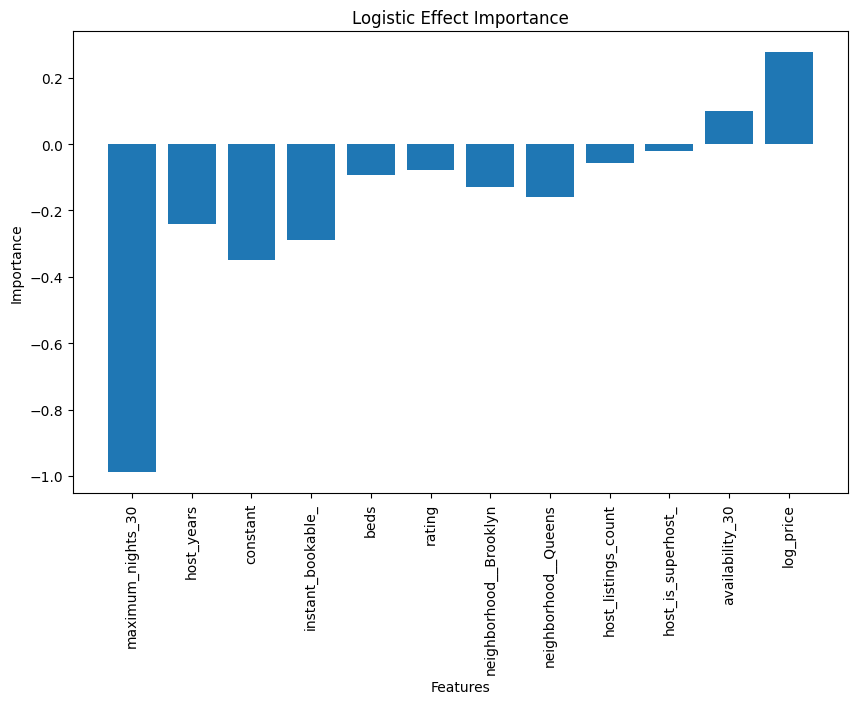

In [18]:
plt.figure(figsize=(10, 6))
plt.bar(feature_importance.index, feature_importance['coefficient'])
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Logistic Effect Importance')
plt.xticks(rotation=90)
plt.show()

In [19]:
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)
y_pred_prob_rf= rf_model.predict(X_test)
y_pred_rf = [1 if x > 0.5 else 0 for x in y_pred_prob_rf]

In [20]:
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.92      0.93      0.93      5224
           1       0.60      0.56      0.58       941

    accuracy                           0.88      6165
   macro avg       0.76      0.74      0.75      6165
weighted avg       0.87      0.88      0.87      6165



In [21]:
rf_importance = rf_model.feature_importances_
rf_feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf_importance
})
rf_feature_importance = rf_feature_importance.sort_values('importance', ascending=False)
rf_feature_importance

,feature,importance
7,maximum_nights_30,0.299535
2,availability_30,0.167980
1,log_price,0.158842
6,host_years,0.146842
4,host_listings_count,0.082026
3,beds,0.050789
5,rating,0.029107
9,host_is_superhost_,0.026351
10,neighborhood__Brooklyn,0.015202
8,instant_bookable_,0.012413


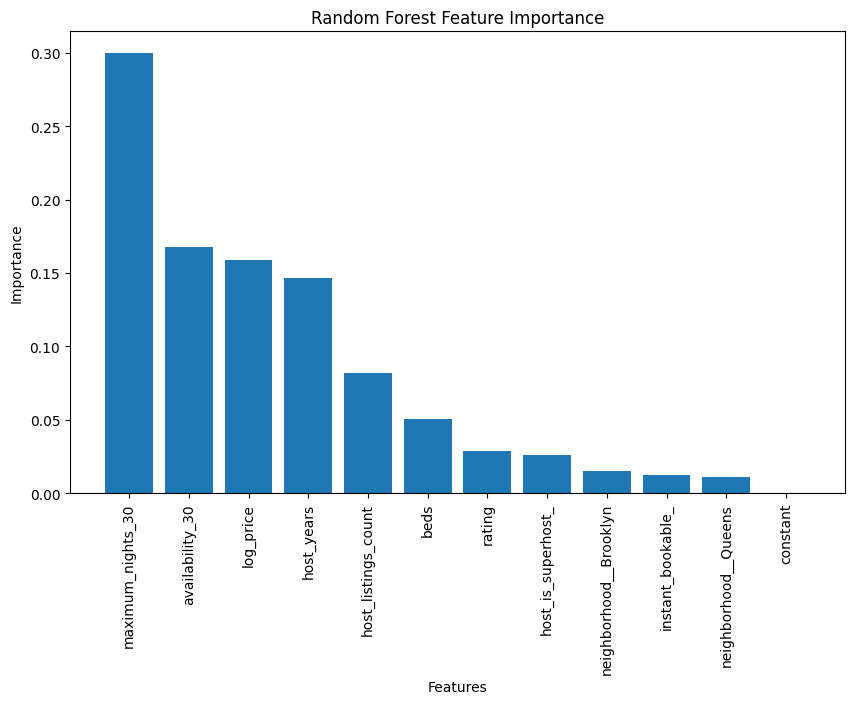

In [22]:
plt.figure(figsize=(10, 6))
plt.bar(rf_feature_importance['feature'], rf_feature_importance['importance'])
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Random Forest Feature Importance')
plt.xticks(rotation=90)
plt.show()